In [1]:
from Data_Extraction_Visualization import XMLExtraction, Visualize
from Data_Retriever import DataRetriever
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
import matplotlib.pyplot as plt
import time
# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
CUDA_LAUNCH_BLOCKING="1"

In [3]:
my_path = '.\ANNOTATIONS'
XML_obj = XMLExtraction(my_path)
data = XML_obj.df

In [4]:
data.head()

,Name,image_path,annotation_path,label
0,crazing_1,.\IMAGES\crazing_1.jpg,.\ANNOTATIONS\crazing_1.xml,crazing
1,crazing_10,.\IMAGES\crazing_10.jpg,.\ANNOTATIONS\crazing_10.xml,crazing
2,crazing_100,.\IMAGES\crazing_100.jpg,.\ANNOTATIONS\crazing_100.xml,crazing
3,crazing_101,.\IMAGES\crazing_101.jpg,.\ANNOTATIONS\crazing_101.xml,crazing
4,crazing_102,.\IMAGES\crazing_102.jpg,.\ANNOTATIONS\crazing_102.xml,crazing


In [5]:
len(data)

1770

In [6]:
labels = data['label'].unique()

In [7]:
color_codes = {}
colors = [(0,0,255), (0,255,0), (255,0,0), (255,255,0), (0,255,255), (255,0,255)]
for ele,color in zip(labels,colors):
    color_codes[ele] = color

In [8]:
viz_obj = Visualize()

In [9]:
color = color_codes.get(data['label'][0])

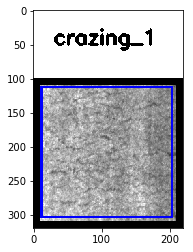

In [10]:
viz_obj.show_defect(data['image_path'][0], data['annotation_path'][0], data['Name'][0], color)

In [11]:
train_df = data[["image_path", "label"]]

In [12]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])

In [13]:
train, test = train_test_split(train_df, test_size=0.33, random_state=123)

In [14]:
len(train)

1185

In [15]:
BATCH = 15
n_class = train_df['label'].nunique()
train_data_retriever = DataRetriever(
    train["image_path"].tolist(),
    train["label"].tolist()
)

test_data_retriever = DataRetriever(
    test["image_path"].tolist(),
    test["label"].tolist()
)

torch.manual_seed(42)
train_loader = DataLoader(train_data_retriever, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_data_retriever, batch_size=BATCH, shuffle=True)

In [16]:
Base_Model1 = models.resnet34(pretrained=True)
for param in Base_Model1.parameters():
    param.requires_grad = False

Base_Model1.fc = nn.Linear(512, n_class, bias=True)

In [17]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [18]:
%%time
EPOCHS = 10
start_time = time.time()
criterion = nn.CrossEntropyLoss()


#configure the model for GPU training
model = Base_Model1.to(DEVICE)
epochs = 0
optimizer = torch.optim.Adam(Base_Model1.parameters(), lr=0.001)    
    
train_losses = []
test_losses = []
train_correct = []
test_correct = []

PATH = 'checkpoint.pth'

if os.path.exists(PATH):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epochs = checkpoint['epoch']
    train_losses = checkpoint['train_loss']
    test_losses = checkpoint['test_loss']
    test_correct = checkpoint['test_correct']
    
for i in range(epochs, EPOCHS):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        X_train = X_train.to(DEVICE)
        y_train = y_train.to(DEVICE)
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%20 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{b:6}/79]  loss: {loss.item():10.8f}  \
            accuracy: {trn_corr.item()*100/(BATCH*b):7.3f}%')
        elif b == 79:
            print(f'epoch: {i:2}  batch: {b:4} [{b:6}/79]  loss: {loss.item():10.8f}  \
            accuracy: {trn_corr.item()*100/(BATCH*b):7.3f}%')
            

    train_losses.append(loss)
    train_correct.append(trn_corr)
    

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            b+=1
            
            X_test = X_test.to(DEVICE)
            y_test = y_test.to(DEVICE)
            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
    checkpoint = {'epoch': i,
                  'state_dict': model.state_dict(),
                  'optimizer' : optimizer.state_dict(),
                  'train_loss' : train_losses,
                  'test_loss' : test_losses,
                  'test_correct':test_correct}

    torch.save(checkpoint, PATH)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   20 [    20/79]  loss: 1.19140506              accuracy:  30.667%
epoch:  0  batch:   40 [    40/79]  loss: 0.95606333              accuracy:  48.333%
epoch:  0  batch:   60 [    60/79]  loss: 1.03751516              accuracy:  57.556%
epoch:  0  batch:   79 [    79/79]  loss: 0.73959941              accuracy:  63.544%
epoch:  1  batch:   20 [    20/79]  loss: 0.65576965              accuracy:  85.000%
epoch:  1  batch:   40 [    40/79]  loss: 0.40819070              accuracy:  85.167%
epoch:  1  batch:   60 [    60/79]  loss: 0.43572536              accuracy:  85.000%
epoch:  1  batch:   79 [    79/79]  loss: 0.55352932              accuracy:  84.473%
epoch:  2  batch:   20 [    20/79]  loss: 0.35370669              accuracy:  86.333%
epoch:  2  batch:   40 [    40/79]  loss: 0.73628467              accuracy:  86.833%
epoch:  2  batch:   60 [    60/79]  loss: 0.31392437              accuracy:  87.000%
epoch:  2  batch:   79 [    79/79]  loss: 0.43403766             

In [19]:
print(f'Test accuracy: {test_correct[-1].item()*100/len(test):.3f}%')

Test accuracy: 88.718%


In [20]:
torch.save(model.state_dict(), 'Resnet34.pt')

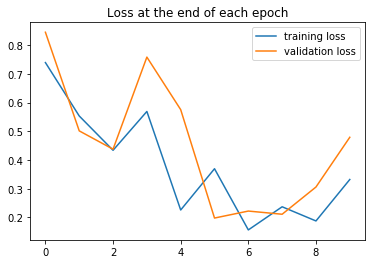

In [21]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

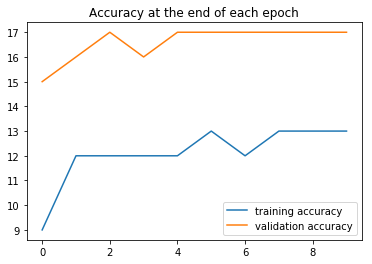

In [22]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();